In [ ]:
import usb.core
import usb.util
import time
import keyboard
import numpy as np
import random
import tkinter as tk
from tkinter import simpledialog
import matplotlib.pyplot as plt

In [ ]:
def setup_usb():
    device = usb.core.find(idVendor=0x0483, idProduct=0x5740)
    out_endpoint = None
    in_endpoint = None
    for cfg in device:
        for intf in cfg:
            for ep in intf:
                if usb.util.endpoint_direction(ep.bEndpointAddress) == usb.util.ENDPOINT_OUT:
                    out_endpoint = ep
                elif usb.util.endpoint_direction(ep.bEndpointAddress) == usb.util.ENDPOINT_IN:
                    in_endpoint = ep

    if out_endpoint is None or in_endpoint is None:
        raise ValueError("Both OUT and IN endpoints are required for communication.")
    device.set_configuration(1)
    return device, out_endpoint, in_endpoint

interface = 0
device, out_endpoint, in_endpoint = setup_usb()
usb.util.claim_interface(device, interface)

def send(data):
    usb.util.claim_interface(device, interface)
    device.write(out_endpoint.bEndpointAddress, data)
    usb.util.release_interface(device, interface)
    usb.util.dispose_resources(device)


def HtB(hex_string):
    hex_values = hex_string.split()
    binary_values = []
    for hex_value in hex_values:
        decimal_value = int(hex_value, 16)
        binary_value = bin(decimal_value)[2:].zfill(8)
        binary_values.append(binary_value)
    return binary_values


def BtH(binary_string):
    binary_values = binary_string.split()
    hex_values = []
    for binary_value in binary_values:
        decimal_value = int(binary_value, 2)
        hex_value = hex(decimal_value)[2:].upper().zfill(2)
        hex_values.append(hex_value)
    return hex_values


def list_glue(string_list):
    s=""
    for i in string_list:
        s+=i
    return s


def hex_xor(hex1, hex2):
    int1 = int(hex1, 16)
    int2 = int(hex2, 16)
    xor_result = int1 ^ int2
    hex_result=format(xor_result, '02X')
    return hex_result


def checksum(hex_sequence):
    crc = 0x0000
    hex_values = hex_sequence.split()
    for hex_value in hex_values:
        data = int(hex_value, 16)
        crc ^= data << 8
        for _ in range(8):
            if crc & 0x8000:
                crc = (crc << 1) ^ 0x1021
            else:
                crc <<= 1
    crc &= 0xFFFF
    crcmodem = format(crc, '04X')
    crc0 = format(crc, '04X')
    return "81" + " " + hex_xor(crc0[:2],'55') + " " + "81" + " " + hex_xor(crc0[2:],'55')


def length_cal(command_str):
    l = 10 + len(command_str.split())
    l = hex(l)[2:]
    l = hex_xor(l,'55')
    return "81" + " " + "55" + " "  + "81"+ " "  + l


def message_gen(data_string):
    m = "F0" + " " + length_cal(data_string)+ " " + checksum(data_string) + " " + data_string + " " + "0F"
    return m


def init():
    command= "00 1E 00"
    send(bytes.fromhex(message_gen(command)))


def stop():
    command= "0C 22"
    send(bytes.fromhex(message_gen(command)))


def get_current_data(): #requests the live data and keep alive signal
    message = message_gen("08 24 02")
    return bytes.fromhex(message)


def split_string(string, block_size):
    string = ''.join(string.split())
    num_blocks = len(string) // block_size
    blocks = [string[i:i+block_size] for i in range(0, len(string), block_size)]
    out = ' '.join(blocks)
    return out


def send_message(pw, amp, frequency, timer):
    message1=update_1point(pw, amp, frequency)
    message2=get_current_data()
    init()
    for _ in range(timer*10):
        send(message1)
        send(message2)
        time.sleep(0.1)
    stop()

def update_Octapulse(channels, amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8): # Channels should be a list of 8 0-1 entries corresponding to targeted channels
    assert len(channels) == 8, "channel must be a list of length 8."
    assert all(arg <= 25 for arg in (amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8)), "All arguments must be 25 or less for safety"
    pw = 120
    frequency = 40
    p1=  bin(pw)[2:].zfill(12) + bin(int(2*amp1)+300)[2:].zfill(10) + "0"*10
    p2=  bin(pw)[2:].zfill(12) + bin(int(2*(-amp1))+300)[2:].zfill(10) + "0"*10
    p3=  bin(pw)[2:].zfill(12) + bin(int(2*amp2)+300)[2:].zfill(10) + "0"*10
    p4=  bin(pw)[2:].zfill(12) + bin(int(2*(-amp2))+300)[2:].zfill(10) + "0"*10
    p5=  bin(pw)[2:].zfill(12) + bin(int(2*amp3)+300)[2:].zfill(10) + "0"*10
    p6=  bin(pw)[2:].zfill(12) + bin(int(2*(-amp3))+300)[2:].zfill(10) + "0"*10
    p7=  bin(pw)[2:].zfill(12) + bin(int(2*amp4)+300)[2:].zfill(10) + "0"*10
    p8=  bin(pw)[2:].zfill(12) + bin(int(2*(-amp4))+300)[2:].zfill(10) + "0"*10
    p9=  bin(pw)[2:].zfill(12) + bin(int(2*amp5)+300)[2:].zfill(10) + "0"*10
    p10= bin(pw)[2:].zfill(12) + bin(int(2*(-amp5))+300)[2:].zfill(10) + "0"*10
    p11= bin(pw)[2:].zfill(12) + bin(int(2*amp6)+300)[2:].zfill(10) + "0"*10
    p12= bin(pw)[2:].zfill(12) + bin(int(2*(-amp6))+300)[2:].zfill(10) + "0"*10
    p13= bin(pw)[2:].zfill(12) + bin(int(2*amp7)+300)[2:].zfill(10) + "0"*10
    p14= bin(pw)[2:].zfill(12) + bin(int(2*(-amp7))+300)[2:].zfill(10) + "0"*10
    p15= bin(pw)[2:].zfill(12) + bin(int(2*amp8)+300)[2:].zfill(10) + "0"*10
    p16= bin(pw)[2:].zfill(12) + bin(int(2*(-amp8))+300)[2:].zfill(10) + "0"*10
    ramp = 3
    block_1_8 =""
    for i in channels:
        block_1_8+=str(i)
    block_2_8 = bin(1)[2:].zfill(4) + bin(ramp)[2:].zfill(4)
    block_3_16 = bin(((1000*2)//frequency))[2:].zfill(15) + "0"
    command_block= "04 20" + " " + split_string(list_glue(BtH(split_string(block_1_8[::-1] + (block_2_8 + block_3_16 + p1 + p2)*channels[0] + (block_2_8 + block_3_16 + p3 + p4)*channels[1]
                                                                           + (block_2_8 + block_3_16 + p5 + p6)*channels[2] + (block_2_8 + block_3_16 + p7 + p8)*channels[3] + (block_2_8
                                                                           + block_3_16+ p9 + p10)*channels[4] + (block_2_8 + block_3_16 + p11 + p12)*channels[5]
                                                                           + (block_2_8 + block_3_16 + p13 + p14)*channels[6] + (block_2_8 + block_3_16 + p15 + p16)*channels[7], 8))), 2)

    CB=command_block.split()
    for i in range(len(CB)):
        if CB[i] in ["0F","F0","81","55","0f","f0"]:
            CB[i]="81" + " " + hex_xor(CB[i], '55')
    CB2=''
    for i in CB:
        CB2 = CB2 + i
    command_block=split_string(''.join(CB2.split()), 2)
    ml_message = "F0" +" " + length_cal(command_block) + " " + checksum(command_block) + " " + command_block + " " + "0F"
    return bytes.fromhex(ml_message)


def send_message8(channels, amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8, timer):
    message1=update_Octapulse(channels, amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8)

    for _ in range(round(timer*50)):
        send(message1)
        time.sleep(0.02)
        if keyboard.is_pressed('s'):
            print("Key 'S' pressed. Exiting the loop.")
            break
    # stop()

init() # initializes the device

def list_message2(amp_list1, amp_list2, dt): # use multipliers of 0.05 seconds
    try:
        message2 = get_current_data()
        update_list=[]

        for k in range(len(amp_list1)):
            i = amp_list1[k]
            j =  amp_list2[k]
            message1=update_2point(i, j)
            update_list.append(message1)
        init()
        l=-1
        if dt<1:
                for s in update_list:
                    l+=1
                    send(s)
                    print("R:", amp_list1[l])
                    print("B:", amp_list2[l])
                    send(message2)
                    time.sleep(dt)
        else:
            for r in update_list:
                l+=1
                print("R:",amp_list1[l])
                print("B:",amp_list2[l])
                for t in range(int(20*dt)):
                    send(r)
                    send(message2)
                    time.sleep(0.05)
        stop()
    except:
        print("Retry")



#Amps rising linearly

def linear(channels, matrix, duration): # each row of the matrix correspond to an activated channel respectively, and the number of rows should
    # be equal to the number of activated channels


    num_activated_channels = sum(channels)

    assert matrix.shape[0] == num_activated_channels, "The matrix must have rows equal to the number of activated channels"
    assert matrix.shape[1] == 2, "The matrix must have 2 columns"

    #full input matrix preparation
    args = [0] * 8
    input=np.zeros((8, matrix.shape[1]), dtype=float)
    matrix_index = 0
    for i, state in enumerate(channels):
        if state == 1:
            input[i] = matrix[matrix_index]
            matrix_index += 1

    start_points = input[:,0].tolist()
    end_points = input[:,1].tolist()
    if len(start_points) != 8 or len(end_points) != 8:
        raise ValueError("There must be exactly 8 start points and 8 end points.")
    step_size = 0.5

    # Calculate the maximum distance and corresponding number of steps
    max_distance = max(abs(end - start) for start, end in zip(start_points, end_points))
    num_steps = int(max_distance / step_size) + 1

    # Generate all lists with step size of 0.5

    all_lists = []
    for start, end in zip(start_points, end_points):
        if end!=0:
            current_list = np.linspace(start, end + step_size, num_steps)
            current_list=current_list*2
            current_list=np.round(current_list)/2
            for i in range(len(current_list)):
                if current_list[i] > end:
                    current_list[i]=end
        else:
            current_list = np.zeros(num_steps)
        all_lists.append(current_list.tolist())

    max_length = max(len(lst) for lst in all_lists)

    plot_data(all_lists)

    init()
    for i in range(max_length):
        current_values = [lst[i] for lst in all_lists]
        print(current_values)
        send_message8(channels, current_values[0], current_values[1], current_values[2], current_values[3], current_values[4], current_values[5], current_values[6], current_values[7], duration/max_length)
        if keyboard.is_pressed('s'):
            print("Key 'S' pressed. Exiting the loop.")
            break
    stop()


# sends random amps to device
def randamp(channels, matrix, steps_number, duration, seed):
    if seed is not None:
        random.seed(seed)

    num_activated_channels = sum(channels)

    assert matrix.shape[0] == num_activated_channels, "The matrix must have rows equal to the number of activated channels"
    assert matrix.shape[1] == 2, "The matrix must have 2 columns"

    args = [0] * 8
    input=np.zeros((8, matrix.shape[1]), dtype=float)
    matrix_index = 0
    for i, state in enumerate(channels):
        if state == 1:
            input[i] = matrix[matrix_index]
            matrix_index += 1

    all_lists = []
    for row in input:
        start, end = row
        values = []
        for _ in range(steps_number):
            value = random.uniform(start, end)
            value = round(value * 2) / 2
            values.append(value)
        all_lists.append(values)

    plot_data(all_lists)

    init()
    for i in range(steps_number):
        current_values = [lst[i] for lst in all_lists]
        print(current_values)
        # print(duration/max_length)
        send_message8(channels, current_values[0], current_values[1], current_values[2], current_values[3], current_values[4], current_values[5], current_values[6], current_values[7], duration)
        # time.sleep(duration)  # Wait for the step size duration
        if keyboard.is_pressed('s'):
            print("Key 'S' pressed. Exiting the loop.")
            break
    stop()


#sends amps as step
def stepamp(channels, matrix, steps_number, duration):


    num_activated_channels = sum(channels)

    assert matrix.shape[0] == num_activated_channels, "The matrix must have rows equal to the number of activated channels"
    assert matrix.shape[1] == 2, "The matrix must have 2 columns"

    args = [0] * 8
    input=np.zeros((8, matrix.shape[1]), dtype=float)
    matrix_index = 0
    for i, state in enumerate(channels):
        if state == 1:
            input[i] = matrix[matrix_index]
            matrix_index += 1

    all_lists = []
    for row in input:
        start, end = row
        step_size = (end - start) / (steps_number - 1)
        values = [round((start + i * step_size)*2)/2 for i in range(steps_number)]
        all_lists.append(values)

    plot_data(all_lists)

    init()
    for i in range(steps_number):
        current_values = [lst[i] for lst in all_lists]
        print(current_values)
        # print(duration/max_length)
        send_message8(channels, current_values[0], current_values[1], current_values[2], current_values[3], current_values[4], current_values[5], current_values[6], current_values[7], duration)
        # time.sleep(duration)
        if keyboard.is_pressed('s'):
            print("Key 'S' pressed. Exiting the loop.")
            break

    stop()

def constant(channels, matrix, duration): # each row of the matrix correspond to an activated channel respectively, and the number of rows should

    num_activated_channels = sum(channels)
    args = [0] * 8
    input=np.zeros((8, matrix.shape[1]), dtype=float)
    matrix_index = 0
    for i, state in enumerate(channels):
        if state == 1:
            input[i] = matrix[matrix_index]
            matrix_index += 1

    current_values = []
    for row in input:
        start, end = row
        values = start
        current_values.append(values)

    print(current_values)

    init()
    send_message8(channels, current_values[0], current_values[1], current_values[2], current_values[3], current_values[4], current_values[5], current_values[6], current_values[7], duration)
    stop()


In [ ]:
def get_channel_vector_linear():
    global channels
    channels = [int(entry.get()) for entry in channel_entries]
    global rows
    rows = sum(channels)
    channel_window.destroy()
    get_matrix_and_scalars_linear()

def get_channel_vector_stepamp():
    global channels
    channels = [int(entry.get()) for entry in channel_entries]

    global rows
    rows = sum(channels)

    channel_window.destroy()
    get_matrix_and_scalars_stepamp()

def get_channel_vector_octa():
    global channels
    channels = [int(entry.get()) for entry in channel_entries]

    global rows
    rows = sum(channels)

    channel_window.destroy()
    get_matrix_and_scalars_octa()

def get_channel_vector_randamp():
    global channels
    channels = [int(entry.get()) for entry in channel_entries]

    global rows
    rows = sum(channels)

    channel_window.destroy()
    get_matrix_and_scalars_randamp()

def execute_and_display_result_stepamp():
    matrix = []
    for i in range(rows):
        row = [float(entry.get()) for entry in matrix_entries[i]]
        matrix.append(row)

    steps_number = int(steps_number_entry.get())
    duration = float(duration_entry.get())

    matrix = np.array(matrix, dtype=float)

    display("Executing the stepamp function...")

    stepamp(channels, matrix, steps_number, duration)

def execute_and_display_result_octa():
    matrix = []
    for i in range(rows):
        row = [float(entry.get()) for entry in matrix_entries[i]]
        matrix.append(row)

    matrix = np.array(matrix, dtype=float)

    display("Executing the octa function...")

    octa(channels, matrix)

def execute_and_display_result_randamp():
    matrix = []
    for i in range(rows):
        row = [float(entry.get()) for entry in matrix_entries[i]]
        matrix.append(row)

    steps_number = int(steps_number_entry.get())
    duration = float(duration_entry.get())
    seed = int(float(seed_entry.get()))  # Convert the seed to an integer

    matrix = np.array(matrix, dtype=float)

    display("Executing the randamp function...", f"Seed : {seed}")

    randamp(channels, matrix, steps_number, duration, seed)

    # save_entries(channels, input, steps_number, duration, seed)

def execute_and_display_result_linear():
    matrix = []
    for i in range(rows):
        row = [float(entry.get()) for entry in matrix_entries[i]]
        matrix.append(row)

    duration = float(duration_entry.get())

    matrix = np.array(matrix, dtype=float)

    display("Executing the linear function...")

    linear(channels, matrix, duration)


In [ ]:
# Linear Amps
# steps_number_entry, duration_entry, seed_entry = 0, 0 , 0
def get_matrix_and_scalars_linear():
    global matrix_window
    matrix_window = tk.Tk()
    matrix_window.title("Matrix and Scalars Input")

    min_amp_label = tk.Label(matrix_window, text="Min Amp")
    min_amp_label.grid(row=0, column=0)

    max_amp_label = tk.Label(matrix_window, text="Max Amp")
    max_amp_label.grid(row=0, column=1)

    global matrix_entries
    matrix_entries = []
    channel_indices = [i + 1 for i, val in enumerate(channels) if val == 1]
    for i in range(rows):
        row_entries = []
        for j in range(2):
            entry = tk.Entry(matrix_window, width=10)
            entry.grid(row=i+1, column=j)
            entry.insert(0, j*10)
            row_entries.append(entry)
        matrix_entries.append(row_entries)

        channel_label = tk.Label(matrix_window, text=f"Channel {channel_indices[i]}")
        channel_label.grid(row=i+1, column=2)

    blank_label1 = tk.Label(matrix_window, text="Duration")
    blank_label1.grid(row=rows+1, column=0, columnspan=2)

    global duration_entry
    duration_entry = tk.Entry(matrix_window, width=10)
    duration_entry.grid(row=rows+2, column=0, columnspan=2)
    duration_entry.insert(0, 10)



    execute_button = tk.Button(matrix_window, text="EXECUTE FUNCTION", command=execute_and_display_result_linear,
                           bg="red", fg="white", font=("Helvetica", 12, "bold"))
    execute_button.grid(row=rows+3, column=0, columnspan=6)

    matrix_window.mainloop()



channel_window = tk.Tk()
channel_window.title("Channel Vector Input")

channel_labels = []
for i in range(8):
    label = tk.Label(channel_window, text=f"Channel {i+1}")
    label.grid(row=0, column=i)
    channel_labels.append(label)

# List to hold the IntVar for each checkbox
channel_entries = []
default_values=[1,1,0,0,0,0,0,0]
for i in range(8):
    var = tk.IntVar(value=default_values[i])  # Variable to hold the state of the checkbox
    checkbox = tk.Checkbutton(channel_window, variable=var)
    checkbox.grid(row=1, column=i)
    channel_entries.append(var)

submit_button = tk.Button(channel_window, text="Submit", command=get_channel_vector_linear)
submit_button.grid(row=2, column=0, columnspan=8)

channel_window.mainloop()

In [ ]:
# STEP Amps
# steps_number_entry, duration_entry, seed_entry = 0, 0 , 0
def get_matrix_and_scalars_stepamp():
    global matrix_window
    matrix_window = tk.Tk()
    matrix_window.title("Matrix and Scalars Input")

    min_amp_label = tk.Label(matrix_window, text="Min Amp")
    min_amp_label.grid(row=0, column=0)

    max_amp_label = tk.Label(matrix_window, text="Max Amp")
    max_amp_label.grid(row=0, column=1)

    global matrix_entries
    matrix_entries = []
    channel_indices = [i + 1 for i, val in enumerate(channels) if val == 1]
    for i in range(rows):
        row_entries = []
        for j in range(2):
            entry = tk.Entry(matrix_window, width=10)
            entry.grid(row=i+1, column=j)
            entry.insert(0, j*10)
            row_entries.append(entry)
        matrix_entries.append(row_entries)

        channel_label = tk.Label(matrix_window, text=f"Channel {channel_indices[i]}")
        channel_label.grid(row=i+1, column=2)

    blank_label1 = tk.Label(matrix_window,text ="Step Number")
    blank_label1.grid(row=rows+1, column=0, columnspan=1)
    blank_label2 = tk.Label(matrix_window,text ="Duration")
    blank_label2.grid(row=rows+1, column=2, columnspan=5)

    global steps_number_entry, duration_entry
    steps_number_entry = tk.Entry(matrix_window, width=10)
    steps_number_entry.grid(row=rows+2, column=0, columnspan=1)
    steps_number_entry.insert(0, 10)
    duration_entry = tk.Entry(matrix_window, width=10)
    duration_entry.grid(row=rows+2, column=2, columnspan=1)
    duration_entry.insert(0, 1)
    execute_button = tk.Button(matrix_window, text="EXECUTE FUNCTION", command=execute_and_display_result_stepamp,
                           bg="red", fg="white", font=("Helvetica", 12, "bold"))
    execute_button.grid(row=rows+3, column=0, columnspan=6)
    matrix_window.mainloop()

channel_window = tk.Tk()
channel_window.title("Channel Vector Input")
channel_labels = []
for i in range(8):
    label = tk.Label(channel_window, text=f"Channel {i+1}")
    label.grid(row=0, column=i)
    channel_labels.append(label)
channel_entries = []
default_values=[1,1,0,0,0,0,0,0]
for i in range(8):
    var = tk.IntVar(value=default_values[i])  # Variable to hold the state of the checkbox
    checkbox = tk.Checkbutton(channel_window, variable=var)
    checkbox.grid(row=1, column=i)
    channel_entries.append(var)

submit_button = tk.Button(channel_window, text="Submit", command=get_channel_vector_stepamp)
submit_button.grid(row=2, column=0, columnspan=8)

channel_window.mainloop()


# parameters = load_entries()
channels = parameters['Channels'] if parameters['Channels'] else [0] * 8

'Executing the randamp function...'

'Seed : 1'

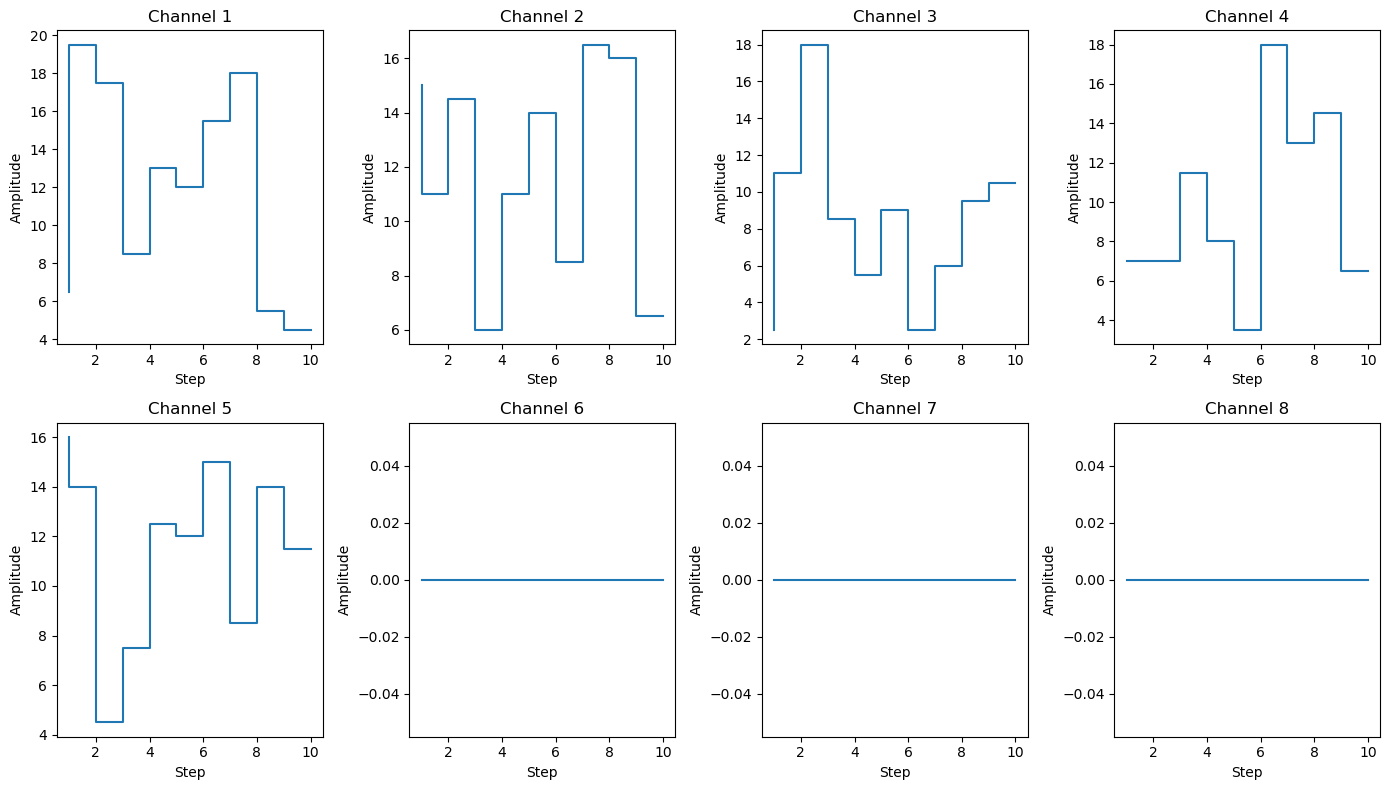

[6.5, 15.0, 2.5, 7.0, 16.0, 0.0, 0.0, 0.0]
[19.5, 11.0, 11.0, 7.0, 14.0, 0.0, 0.0, 0.0]
[17.5, 14.5, 18.0, 7.0, 4.5, 0.0, 0.0, 0.0]
[8.5, 6.0, 8.5, 11.5, 7.5, 0.0, 0.0, 0.0]
[13.0, 11.0, 5.5, 8.0, 12.5, 0.0, 0.0, 0.0]
[12.0, 14.0, 9.0, 3.5, 12.0, 0.0, 0.0, 0.0]
[15.5, 8.5, 2.5, 18.0, 15.0, 0.0, 0.0, 0.0]
[18.0, 16.5, 6.0, 13.0, 8.5, 0.0, 0.0, 0.0]
[5.5, 16.0, 9.5, 14.5, 14.0, 0.0, 0.0, 0.0]
[4.5, 6.5, 10.5, 6.5, 11.5, 0.0, 0.0, 0.0]


In [ ]:
# RANDOM Amps
# steps_number_entry, duration_entry, seed_entry = 0, 0 , 0
def get_matrix_and_scalars_randamp():
    global matrix_window
    matrix_window = tk.Tk()
    matrix_window.title("Matrix and Scalars Input")

    min_amp_label = tk.Label(matrix_window, text="Min Amp")
    min_amp_label.grid(row=0, column=0)

    max_amp_label = tk.Label(matrix_window, text="Max Amp")
    max_amp_label.grid(row=0, column=1)

    global matrix_entries
    matrix_entries = []
    channel_indices = [i + 1 for i, val in enumerate(channels) if val == 1]
    for i in range(rows):
        row_entries = []
        for j in range(2):
            entry = tk.Entry(matrix_window, width=10)
            entry.grid(row=i+1, column=j)
            entry.insert(0, j*10)
            row_entries.append(entry)
        matrix_entries.append(row_entries)

        channel_label = tk.Label(matrix_window, text=f"Channel {channel_indices[i]}")
        channel_label.grid(row=i+1, column=2)

    blank_label1 = tk.Label(matrix_window, text="Step number")
    blank_label1.grid(row=rows+1, column=0, columnspan=1)

    blank_label2 = tk.Label(matrix_window, text="Duration")
    blank_label2.grid(row=rows+1, column=1, columnspan=1)

    blank_label3 = tk.Label(matrix_window, text="Seed")
    blank_label3.grid(row=rows+1, column=2, columnspan=1)

    global steps_number_entry, duration_entry, seed_entry
    steps_number_entry = tk.Entry(matrix_window, width=10)
    steps_number_entry.grid(row=rows+2, column=0, columnspan=1)
    steps_number_entry.insert(0, 10)

    duration_entry = tk.Entry(matrix_window, width=10)
    duration_entry.grid(row=rows+2, column=1, columnspan=1)
    duration_entry.insert(0, 1)

    seed_entry = tk.Entry(matrix_window, width=10)
    seed_entry.grid(row=rows+2, column=2, columnspan=1)
    seed_entry.insert(0, 1)


    execute_button = tk.Button(matrix_window, text="EXECUTE FUNCTION", command=execute_and_display_result_randamp,
                           bg="red", fg="white", font=("Helvetica", 12, "bold"))
    execute_button.grid(row=rows+3, column=0, columnspan=6)

    matrix_window.mainloop()


channel_window = tk.Tk()
channel_window.title("Channel Vector Input")

channel_labels = []
for i in range(8):
    label = tk.Label(channel_window, text=f"Channel {i+1}")
    label.grid(row=0, column=i)
    channel_labels.append(label)

channel_entries = []
default_values=[1,1,0,0,0,0,0,0]
for i in range(8):
    var = tk.IntVar(value=default_values[i])  # Variable to hold the state of the checkbox
    checkbox = tk.Checkbutton(channel_window, variable=var)
    checkbox.grid(row=1, column=i)
    channel_entries.append(var)

submit_button = tk.Button(channel_window, text="Submit", command=get_channel_vector_randamp)
submit_button.grid(row=2, column=0, columnspan=8)

channel_window.mainloop()

In [ ]:
# Constant
# steps_number, duration, seed= 0, 0 , 0
def get_channel_vector_constant():
    global channels
    channels = [int(entry.get()) for entry in channel_entries]

    global rows
    rows = sum(channels)

    channel_window.destroy()
    get_matrix_and_scalars_constant()

def execute_and_display_result_constant():
    matrix = []
    for i in range(rows):
        row_value = float(matrix_entries[i].get())
        row = [row_value, row_value]  # Duplicate the entry for the second column
        matrix.append(row)

    duration = float(duration_entry.get())

    matrix = np.array(matrix, dtype=float)
    display("Executing the constant function...")

    constant(channels, matrix, duration)

def get_matrix_and_scalars_constant():
    global matrix_window
    matrix_window = tk.Tk()
    matrix_window.title("Matrix and Scalars Input")

    amp_label = tk.Label(matrix_window, text="Amp")
    amp_label.grid(row=0, column=0)

    global matrix_entries
    matrix_entries = []
    channel_indices = [i + 1 for i, val in enumerate(channels) if val == 1]
    for i in range(rows):
        entry = tk.Entry(matrix_window, width=10)
        entry.grid(row=i+1, column=0)
        entry.insert(0, 10)
        matrix_entries.append(entry)
        channel_label = tk.Label(matrix_window, text=f"Channel {channel_indices[i]}")
        channel_label.grid(row=i+1, column=1)

    blank_label1 = tk.Label(matrix_window, text="Duration")
    blank_label1.grid(row=rows+1, column=0, columnspan=1)

    global duration_entry
    duration_entry = tk.Entry(matrix_window, width=10)
    duration_entry.grid(row=rows+2, column=0, columnspan=1)
    duration_entry.insert(0, 2)

    execute_button = tk.Button(matrix_window, text="EXECUTE FUNCTION", command=execute_and_display_result_constant,
                               bg="red", fg="white", font=("Helvetica", 12, "bold"))
    execute_button.grid(row=rows+3, column=0, columnspan=4)

    matrix_window.mainloop()

channel_window = tk.Tk()
channel_window.title("Channel Vector Input")


channel_labels = []
for i in range(8):
    label = tk.Label(channel_window, text=f"Channel {i+1}")
    label.grid(row=0, column=i)
    channel_labels.append(label)

channel_entries = []
default_values=[1,1,0,0,0,0,0,0]
for i in range(8):
    var = tk.IntVar(value=default_values[i])  # Variable to hold the state of the checkbox
    checkbox = tk.Checkbutton(channel_window, variable=var)
    checkbox.grid(row=1, column=i)
    channel_entries.append(var)

submit_button = tk.Button(channel_window, text="Submit", command=get_channel_vector_constant)
submit_button.grid(row=2, column=0, columnspan=8)

channel_window.mainloop()


'Executing the constant function...'

[20.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


'Executing the constant function...'

[23.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
